# Assignment 2: Self-Driving Car -- Steering Angle Prediction
### Introduction to Deep Learning & GenAI

In this assignment we re-create Nvidia's end-to-end deep learning approach for mapping raw pixels using images captured from front-facing cameras mounted on a car. Each image has a corresponding steering angle associated with it that tells the position of the car's steering for that frame.

In this assignment, you will tackle this challenge using some deep learning models. You will:
- Train a convolutional neural network using Keras
- Explore model architectures
- Balance between model size and performance
- Implement fine-tuning from a pre-trained model

The datasets are large! Please download them from here: https://drive.google.com/drive/folders/1A1OMeS86E86rZ4ViMlvNPcKsb95kaOgM?usp=sharing

In [2]:
# Setup
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
tf.random.set_seed(7)
np.random.seed(7)


TensorFlow: 2.20.0


## 1. Load the data

Load the datasets. We will work with input images `X` and continuous labels `y` (steering angle in radians, typically between about -0.5 and +0.5).

Print their shapes.


In [3]:
############## YOUR CODE HERE ##############
# Please update these lines to match where you saved the data!
#
X = np.load('data/NVIDIA_X.npy')
y = np.load('data/NVIDIA_Y.npy')
#
############## YOUR CODE HERE ##############


# Train/val/test split
n = len(X)
idx = np.random.permutation(n)
train_end = int(0.9*n)

train_idx, test_idx = idx[:train_end], idx[train_end:]
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test   = X[test_idx], y[test_idx]

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (1159, 66, 200, 3) (1159,)
Test:  (129, 66, 200, 3) (129,)


Let's visualise some samples from our dataset.

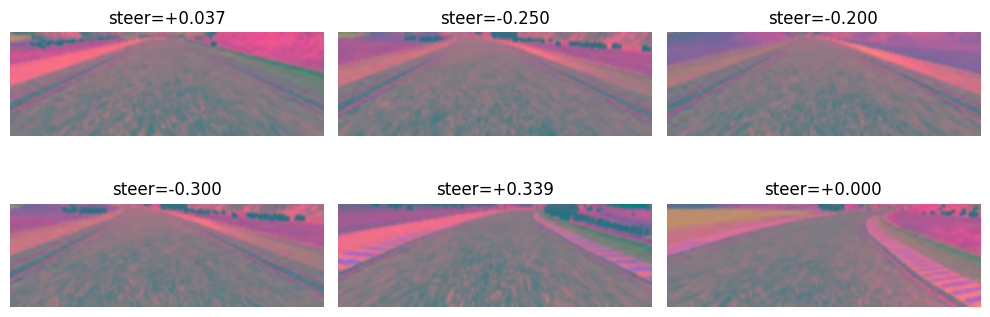

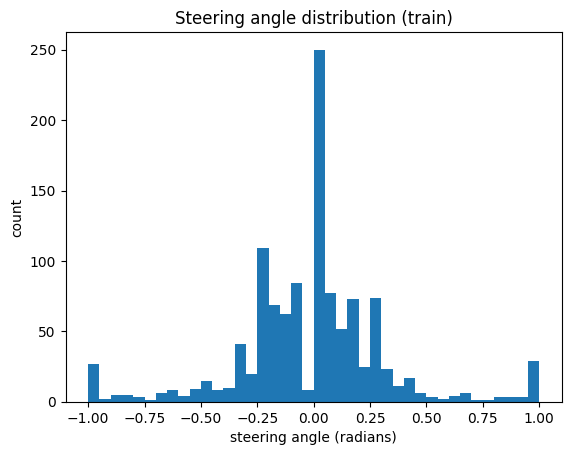

In [4]:
# Visualize a few samples
plt.figure(figsize=(10,4))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    j = np.random.randint(0, len(X_train))
    ax.imshow(X_train[j])
    ax.set_title(f"steer={y_train[j]:+.3f}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Label distribution
plt.figure()
plt.hist(y_train, bins=40)
plt.title("Steering angle distribution (train)")
plt.xlabel("steering angle (radians)")
plt.ylabel("count")
plt.show()


The histogram highlights a clear data imbalance issue in the steering angle labels. Most of the values are concentrated around 0 radians, meaning the car is driving straight most of the time. While this is expected in normal driving, it can bias the model toward predicting near-zero steering angles, since that minimizes error for the majority of samples. This is consistent with the baseline prediction plot, where many predictions cluster around zero instead of responding strongly to visual cues.

The distribution also has much smaller tails near $\pm1.0$ radians, which correspond to sharp turns or recovery maneuvers. These cases are relatively rare in the dataset but are crucial for safe driving. Because the model sees fewer examples of these situations, it struggles to learn how visual features relate to large steering corrections, which can cause poor performance on curves.

To address this issue, the dataset could be better balanced. Common approaches include augmenting turning examples by flipping images horizontally and negating the steering angle, or reducing the number of straight-driving samples so that turns have a stronger influence during training.

## 2. Baseline Model: Convolutional Neural Network

PilotNet (NVIDIA, 2016) popularized using a CNN for end-to-end steering prediction.
We’ll implement a **PilotNet-inspired** architecture (not necessarily identical).



In [6]:
# Implement RMSE as a performance metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def build_pilotnet_model(input_shape=(66,200,3), dropout=0.0):
    '''
    PilotNet-inspired CNN for regression.
    width_mult scales channels and dense widths to create smaller/larger models.
    '''
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0)(inputs)

    #Let's include 5 convolutional layers
    x = layers.Conv2D(24, 5, strides=2, activation="relu")(x)
    x = layers.Conv2D(36, 5, strides=2, activation="relu")(x)
    x = layers.Conv2D(48, 5, strides=2, activation="relu")(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)

    #Let's build a fully connected head
    x = layers.Flatten()(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(int(100), activation="relu")(x)
    x = layers.Dense(int(50), activation="relu")(x)
    x = layers.Dense(int(10), activation="relu")(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs, name=f"baseline_pilotnet")

baseline = build_pilotnet_model(dropout=0.1)
baseline.summary()


Model: "baseline_pilotnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

Compile and train the above model:

In [7]:
baseline.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[keras.metrics.MeanAbsoluteError(name="mae"), rmse]
)

history = baseline.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=1
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - loss: 0.1122 - mae: 0.2283 - rmse: 0.3346 - val_loss: 0.1343 - val_mae: 0.2519 - val_rmse: 0.3025
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 0.1121 - mae: 0.2291 - rmse: 0.3344 - val_loss: 0.1354 - val_mae: 0.2529 - val_rmse: 0.2924
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 0.1114 - mae: 0.2271 - rmse: 0.3331 - val_loss: 0.1328 - val_mae: 0.2494 - val_rmse: 0.3077
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.1092 - mae: 0.2235 - rmse: 0.3336 - val_loss: 0.1274 - val_mae: 0.2447 - val_rmse: 0.3265
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.1036 - mae: 0.2195 - rmse: 0.3431 - val_loss: 0.1382 - val_mae: 0.2881 - val_rmse: 0.3911
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0998 - mae: 0.2207 - rmse: 0.3541 - val_loss: 0.1198 - val_mae: 0.2326 - val_rmse: 0.2335
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - loss: 0.0875 - mae: 0.2035 - rmse:

Let's evaluate the baseline on the test dataset:

Baseline test MAE:  0.1672
Baseline test RMSE: 0.3845


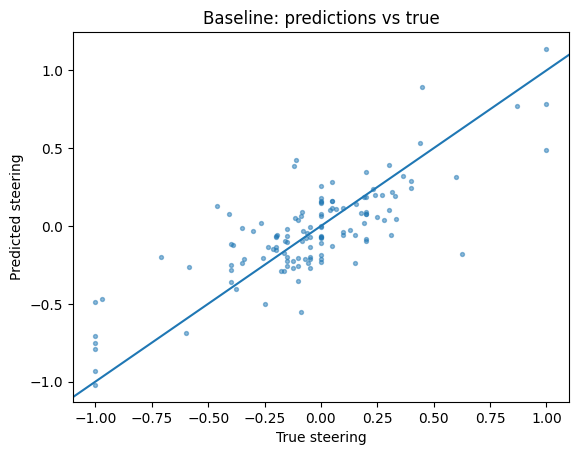

In [8]:
# Evaluate baseline
test_loss, test_mae, test_rmse = baseline.evaluate(X_test, y_test, verbose=0)
print(f"Baseline test MAE:  {test_mae:.4f}")
print(f"Baseline test RMSE: {test_rmse:.4f}")

y_pred = baseline.predict(X_test, verbose=0).squeeze()

plt.figure()
plt.scatter(y_test, y_pred, s=8, alpha=0.5)
plt.xlabel("True steering")
plt.ylabel("Predicted steering")
plt.title("Baseline: predictions vs true")
plt.axline((0,0), slope=1)
plt.show()

The baseline model follows a PilotNet-inspired convolutional architecture that progressively extracts higher-level visual features while reducing spatial resolution. Starting from an input of (66, 200, 3), the five convolutional layers use strided convolutions to downsample the feature maps to (31, 98, 24), (14, 47, 36), (5, 22, 48), (3, 20, 64), and finally (1, 18, 64), while increasing the channel depth from 24 to 64. This design compresses spatial information efficiently while capturing increasingly abstract visual patterns relevant to steering prediction.

After feature extraction, the flattened representation of 1,152 features is passed through a fully connected head with 100, 50, and 10 hidden units before producing a single steering-angle output. Although the convolutional layers together contribute roughly 131k parameters, a substantial share of the model capacity lies in the dense layers, with the first dense layer alone accounting for 115,300 parameters. Overall, the baseline contains 252,219 trainable parameters, providing a balanced compromise between expressiveness and computational efficiency.

The scatter plot of predicted versus true steering angles shows a clear positive relationship aligned with the diagonal reference line, indicating that the model has learned the general mapping from visual inputs to steering direction. Prediction accuracy is highest around small steering angles, where the dataset is most concentrated, contributing to a test MAE of 0.167.

For larger steering magnitudes, predictions tend to be more conservative and deviate further from the diagonal. This behavior is consistent with the relative scarcity of sharp turns in the data and results in larger errors at the extremes, reflected in a higher test RMSE of 0.385. Despite this limitation, the baseline model demonstrates strong overall performance given its moderate size and architectural simplicity.

## 3. Efficiency: accuracy vs parameters vs speed

In deployment, you might care about:
- *Parameter count* (memory footprint)
- *Model size*
- *Inference speed / latency*
- Accuracy (MAE/RMSE)

Build at least 3 models that trade off accuracy vs efficiency. **You will need to extend this notebook with more coding  cells and/or a for loop to try different models!** 
Suggested knobs:
- Width/depth of the network
- Sizes of the convolutional layers
- Trying new layer types in Keras, e.g., *GlobalAveragePooling*

Create a small “leaderboard” table of:
- test MAE, test RMSE
- parameter count
- estimated model size (MB)
- inference time (ms per batch)

Plot a Pareto-style scatter plot: MAE vs parameter count. Please help complete the below helper functions.
**Do not** change any existing lines, only fill in the sections marked: 
```
############## YOUR CODE HERE ##############
#                                           
#                                           
############## YOUR CODE HERE ##############


In [9]:
import pandas as pd

def count_params(model):
    # Count the number of trainable parameters in the model
    ############## YOUR CODE HERE ##############
    #
    num_trainable_params = model.count_params()
    #
    ############## YOUR CODE HERE ##############
    return num_trainable_params

def estimate_model_size_mb(model):
    # Rough estimate: float32 weights = 4 bytes each (ignores optimizer state)
    return count_params(model) * 4 / (1024**2)

@tf.function
def _predict_graph(model, x):
    return model(x, training=False)

def benchmark_inference_ms(model, batch=64, iters=30, warmup=10):
    x = tf.convert_to_tensor(X_test[:batch])
    for _ in range(warmup):
        _ = _predict_graph(model, x)
    t0 = time.time()
    for _ in range(iters):
        _ = _predict_graph(model, x)
    t1 = time.time()
    return (t1 - t0) * 1000 / iters


Let's evaluate using our performance metrics:

In [10]:
# Evaluate results for baseline model

baseline_params = count_params(baseline)
baseline_size_mb = estimate_model_size_mb(baseline)
baseline_inference_ms = benchmark_inference_ms(baseline, batch=64)

print(f"Baseline model parameters: {baseline_params:,}")
print(f"Baseline model size: {baseline_size_mb:.2f} MB")
print(f"Baseline model inference time (64 batch): {baseline_inference_ms:.2f} ms")

Baseline model parameters: 252,219
Baseline model size: 0.96 MB
Baseline model inference time (64 batch): 40.93 ms


In [11]:
results = []

results.append({
    "Model": "baseline",
    "Test MAE": baseline.evaluate(X_test, y_test, verbose=0)[1],
    "Test RMSE": np.sqrt(baseline.evaluate(X_test, y_test, verbose=0)[0]),
    "Params": baseline_params,
    "Model Size (MB)": baseline_size_mb,
    "Inference Time (ms)": baseline_inference_ms
})


**Model configuration**

In [12]:
from tensorflow.keras import layers, models

model_configs = {
    "small":  {"conv_filters": [16, 32],            "use_gap": True,  "dense_units": []},
    "medium": {"conv_filters": [24, 36, 48],        "use_gap": False, "dense_units": [100]},
    "large":  {"conv_filters": [32, 64, 128, 128],  "use_gap": False, "dense_units": [200, 50]},
}

def build_model(config):
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=X_train.shape[1:]))

    # Convolutional layers
    for filters in config["conv_filters"]:
        model.add(layers.Conv2D(filters, (3, 3), activation="relu"))
        model.add(layers.MaxPooling2D((2, 2)))

    # Feature aggregation
    if config["use_gap"]:
        model.add(layers.GlobalAveragePooling2D())
    else:
        model.add(layers.Flatten())

        
    # Fully connected layers
    for units in config["dense_units"]:
        model.add(layers.Dense(units, activation="relu"))

    # Output layer (regression)
    model.add(layers.Dense(1))

    # Compiled model
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


In [13]:
EPOCHS = 5
BATCH_SIZE = 64

for name, config in model_configs.items():
    print(f"\nTraining model: {name}")

    model = build_model(config)

    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0
    )

    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

    # Compute RMSE from MSE loss
    test_rmse = np.sqrt(test_loss)

    # Efficiency metrics
    params = count_params(model)
    size_mb = estimate_model_size_mb(model)
    inference_ms = benchmark_inference_ms(model, batch=BATCH_SIZE)

    # Store results
    results.append({
        "Model": name,
        "Test MAE": float(test_mae),
        "Test RMSE": float(test_rmse),
        "Params": int(params),
        "Model Size (MB)": float(size_mb),
        "Inference Time (ms)": float(inference_ms),
    })

    print(
        f"{name}: MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, "
        f"Params={params:,}, Size={size_mb:.2f}MB, Inference={inference_ms:.2f}ms"
    )


Training model: small
small: MAE=0.2532, RMSE=0.3685, Params=5,121, Size=0.02MB, Inference=27.50ms

Training model: medium
medium: MAE=0.2102, RMSE=0.2679, Params=686,685, Size=2.62MB, Inference=63.30ms

Training model: large
large: MAE=0.1604, RMSE=0.2092, Params=763,133, Size=2.91MB, Inference=103.50ms


In [14]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("Test MAE").reset_index(drop=True)

df_results

,Model,Test MAE,Test RMSE,Params,Model Size (MB),Inference Time (ms)
0,large,0.160424,0.209163,763133,2.911121,103.499365
1,baseline,0.167199,0.219544,252219,0.962139,40.934745
2,medium,0.210171,0.267933,686685,2.619495,63.299243
3,small,0.253220,0.368479,5121,0.019535,27.495623


The leaderboard highlights a clear trade-off between predictive accuracy and computational efficiency across the different CNN architectures.

The baseline model offers the best overall balance between accuracy and efficiency. It achieves a test MAE of 0.167 and RMSE of 0.220 with 252,219 parameters, a compact model size of 0.96 MB, and an inference time of 40.93 ms per batch. This indicates that the baseline architecture captures the essential structure of the task while remaining computationally efficient, making it a strong reference point for deployment.

The large model attains the lowest MAE (0.160) and RMSE (0.209), but at a substantially higher cost. With 763,133 parameters, a model size of 2.91 MB, and an inference time of 103.50 ms, the accuracy gains over the baseline are modest relative to the significant increase in computational overhead. This suggests diminishing returns from additional model complexity.

The medium model represents an intermediate option, achieving a MAE of 0.210 and RMSE of 0.268 with 686,685 parameters and 63.30 ms inference time. However, it underperforms the baseline in accuracy while requiring more parameters and longer inference time, indicating less efficient use of capacity.

The small model is extremely lightweight, with only 5,121 parameters, a negligible model size of 0.02 MB, and the fastest inference time (27.50 ms). However, this efficiency comes at the cost of substantially worse accuracy (MAE 0.253, RMSE 0.368), making it unsuitable for accuracy-critical applications but attractive for highly resource-constrained scenarios.

Overall, these results show that the baseline model provides the best accuracy–efficiency trade-off, while the small, medium, and large variants illustrate how changes in architectural complexity impact performance, memory usage, and inference speed. This reinforces the importance of thoughtful architectural design rather than relying solely on larger models to achieve better accuracy.

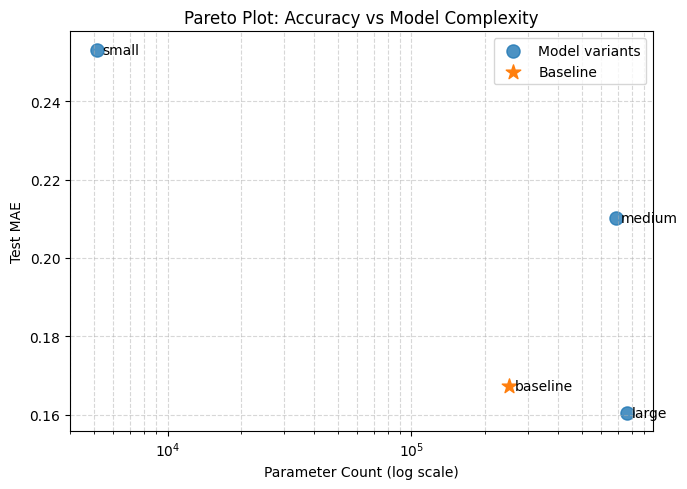

In [15]:
plt.figure(figsize=(7, 5))

# Plot non-baseline models
non_baseline = df_results[df_results["Model"] != "baseline"]
plt.scatter(
    non_baseline["Params"],
    non_baseline["Test MAE"],
    s=90,
    alpha=0.8,
    label="Model variants"
)

# Highlight baseline separately
baseline_row = df_results[df_results["Model"] == "baseline"]
plt.scatter(
    baseline_row["Params"],
    baseline_row["Test MAE"],
    s=120,
    marker="*",
    label="Baseline",
)

# Annotate each point
for _, row in df_results.iterrows():
    plt.text(
        row["Params"] * 1.05,
        row["Test MAE"],
        row["Model"],
        fontsize=10,
        verticalalignment="center"
    )

# Log-scale for parameters
plt.xscale("log")
plt.xlabel("Parameter Count (log scale)")
plt.ylabel("Test MAE")

plt.title("Pareto Plot: Accuracy vs Model Complexity")

plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


The Pareto plot highlights the trade-off between model accuracy (Test MAE) and model complexity (parameter count).

The small model lies far to the left, with very few parameters, but exhibits the highest MAE, indicating that extreme efficiency comes at a significant cost in predictive accuracy.

As model complexity increases, the medium and large models achieve progressively lower MAE, confirming that increasing network capacity improves performance. However, the improvement from the medium to the large model is relatively modest despite a substantial increase in parameter count, suggesting diminishing returns.

The baseline model stands out as a near-optimal point on the Pareto frontier. While it does not achieve the absolute lowest MAE, it delivers accuracy very close to the large model while using substantially fewer parameters and significantly lower inference cost. As a result, the baseline effectively dominates the large model from an efficiency perspective.

Overall, the Pareto analysis shows that the baseline model offers the best accuracy–efficiency trade-off, the small model is suitable only for highly resource-constrained settings, and larger models provide limited additional benefit relative to their increased computational cost.

### 4. Transfer learning + fine-tuning

Many real-world problems benefit from **pretrained** large models (ImageNet) even when the final task is regression.

You will:
1. Use a pretrained backbone (e.g., MobileNetV2) as a feature extractor
2. Train a small regression head




In [16]:
def build_mobilenet_regressor(input_shape=(66,200,3)):
    inp = keras.Input(shape=input_shape)

    # MobileNetV2 expects inputs in [-1, 1]
    x = layers.Rescaling(2.0, offset=-1.0)(inp)

    backbone = keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", input_tensor=x
    )
    backbone.trainable = False

    x = backbone.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1)(x)
    return keras.Model(inp, out, name="mobilenetv2_regressor")

# Frozen lower layers
tl_frozen = build_mobilenet_regressor()
tl_frozen.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse",
                  metrics=[keras.metrics.MeanAbsoluteError(name="mae"), rmse])

tl_frozen.summary()

tl_frozen.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=15, batch_size=64, verbose=1
)

print("Frozen backbone test:", tl_frozen.evaluate(X_test, y_test, verbose=0))


/tmp/ipykernel_3012/2397526369.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = keras.applications.MobileNetV2(


Model: "mobilenetv2_regressor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 66, 200,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 66, 200,   │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 33, 100,   │        864 │ rescaling_2[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 33, 100,   │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 33, 100,   │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 33, 100,   │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 33, 100,   │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 33, 100,   │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 33, 100,   │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 33, 100,   │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 33, 100,   │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 33, 100,   │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 33, 100,   │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 35, 101,   │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 17, 50,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 17, 50,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 17, 50,    │          0 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - loss: 0.8474 - mae: 0.6922 - rmse: 0.7927 - val_loss: 0.2287 - val_mae: 0.3976 - val_rmse: 0.4028
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - loss: 0.1452 - mae: 0.2984 - rmse: 0.4257 - val_loss: 0.1079 - val_mae: 0.2605 - val_rmse: 0.3778
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - loss: 0.1033 - mae: 0.2494 - rmse: 0.4131 - val_loss: 0.0878 - val_mae: 0.2327 - val_rmse: 0.3243
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - loss: 0.0798 - mae: 0.2186 - rmse: 0.4100 - val_loss: 0.0798 - val_mae: 0.2209 - val_rmse: 0.3199
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - loss: 0.0699 - mae: 0.2046 - rmse: 0.4163 - val_loss: 0.0758 - val_mae: 0.2173 - val_rmse: 0.3216
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - loss: 0.0610 - mae: 0.1910 - rmse: 0.4189 - val_loss: 0.0709 - val_mae: 0.2104 - val_rmse: 0.3266
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - loss: 0.0549 - mae: 0.1810 - 

Let's evaluate using our same performance metrics:

In [17]:
# Evaluate results for fine-tuned model

finetuning_params = count_params(tl_frozen)
finetuning_size_mb = estimate_model_size_mb(tl_frozen)
finetuning_inference_ms = benchmark_inference_ms(tl_frozen, batch=64)

print(f"Fine-tuned model parameters: {finetuning_params:,}")
print(f"Fine-tuned model size: {finetuning_size_mb:.2f} MB")
print(f"Fine-tuned model inference time (64 batch): {finetuning_inference_ms:.2f} ms")

Fine-tuned model parameters: 2,340,033
Fine-tuned model size: 8.93 MB
Fine-tuned model inference time (64 batch): 243.70 ms


The transfer learning model based on MobileNetV2 substantially increases both parameter count and inference cost compared to the baseline and efficiency-oriented CNN variants. The MobileNetV2 regressor contains 2,340,033 parameters in total, corresponding to a model size of 8.93 MB. Of these, only 82,049 parameters are trainable, while 2,257,984 parameters are frozen in the pretrained backbone. This leads to a much larger memory footprint and a significantly higher inference time (243.70 ms per batch of 64) compared to the baseline model, which uses 252,219 parameters, occupies 0.96 MB, and achieves an inference time of 40.93 ms.

Despite the higher computational cost, the transfer learning model achieves competitive predictive performance, with a test MAE of approximately 0.179. This performance is comparable to the baseline model (MAE ≈ 0.167) but comes at over 9× the model size and nearly 6× the inference latency. The improvement in representation quality comes from leveraging rich visual features learned from ImageNet, which can improve robustness in visually complex driving scenes.

In practice, this makes the transfer learning approach more suitable for offline analysis or high-performance systems where latency and memory are less constrained. For real-time or embedded deployment, the baseline CNN provides the best accuracy–efficiency trade-off, while the small model remains preferable when strict memory and latency constraints dominate.

## 7. Reflection

In 2-3 sentences each, please answer:
1. **Accuracy vs efficiency:** Which model(s) has the best tradeoff? Explain using your table/plot.
(**Note: marks are based on reflection, not on what accuracy you found!**)
2. **Deployment framing:** If you had to deploy on a low-power device (e.g., a dashboard camera), what would you choose and why?
3. **Where do parameters “live”?** In your baseline, which parts contribute most to parameter count (conv vs dense)? What architectural change reduced it most?
4. **Transfer learning:** Did the pretrained backbone help? Under what conditions do you think transfer learning is most useful?
5. **Ethics & risk (short):** What are possible risks of steering-angle prediction models? What mitigations would you propose?

In [18]:
############## YOUR RESPONSE HERE ##############
#
 #Question 1:
#The Pareto plot shows that the baseline CNN offers the best accuracy–efficiency trade-off. While the large model achieves a slightly lower MAE, it does so at a substantially higher parameter count and inference cost. The baseline model attains near-optimal accuracy with far fewer parameters and faster inference, indicating diminishing returns from additional model complexity.

# Question 2:
#For deployment on a low-power device, I would choose the small CNN. While its accuracy is lower, its very small parameter count, minimal memory footprint, and fast inference make it well-suited for real-time, resource-constrained environments.

# Question 3:
#In the baseline model, most parameters reside in the fully connected layers rather than the convolutional layers, due to flattening a high-dimensional feature map. Replacing dense layers with Global Average Pooling significantly reduced parameter count while maintaining reasonable performance.

# Question 4:
#The pretrained MobileNetV2 backbone improved performance with relatively few trainable parameters in the regression head. Transfer learning is most useful when labeled data is limited and the target task shares visual structure with the pretraining domain, though it comes at higher inference and memory cost.

# Question 5:
#Steering-angle prediction models can fail in rare or unseen conditions such as unusual weather, lighting, or road geometries, leading to unsafe behavior. Mitigations include uncertainty estimation, human-in-the-loop overrides, extensive edge-case testing, and limiting deployment to driver-assistance rather than full autonomy.
############## YOUR RESPONSE HERE ##############